## Imports & basic setup

In [3]:
# Cell 2: Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# Make plots a bit prettier
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)


## Download VADER lexicon

In [4]:
# Cell 3: Download VADER lexicon for sentiment analysis (only first time)
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...


# Create a small sample review dataset

In [19]:


import pandas as pd

# 1. Define the path to your CSV file
# Replace 'path/to/your/app_reviews.csv' with the actual file path
# If the file is in your project root, you might just use 'app_reviews.csv'
file_path = '../Data/Processed/reviews_processed.csv'

# 2. Load the data into a DataFrame
# Use 'encoding' or 'sep' (separator) arguments if necessary
df = pd.read_csv(file_path)

# 3. Display the first few rows
df.head()


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source
0,3d88a334-958c-4717-9f97-c5d46359e054,It is nice app,5,2025-11-26,2025,11,CBE,Commercial Bank of Ethiopia,A Google user,0,14,Google Play
1,99d376ea-4824-4af9-a093-27360acc3a5c,best,5,2025-11-25,2025,11,CBE,Commercial Bank of Ethiopia,A Google user,0,4,Google Play
2,f1861daf-a1ed-407a-9e7c-295edbb3877d,good app,5,2025-11-25,2025,11,CBE,Commercial Bank of Ethiopia,A Google user,0,8,Google Play
3,fd178fb7-7026-4d02-98a0-5c86c3bd56f5,it suddenly asked me to enter the verification...,1,2025-11-25,2025,11,CBE,Commercial Bank of Ethiopia,A Google user,0,286,Google Play
4,571c66c6-fd18-437b-b8e5-8c443e9db2df,nice app...,5,2025-11-25,2025,11,CBE,Commercial Bank of Ethiopia,A Google user,0,11,Google Play


## Map star ratings → sentiment labels (for ML)

In [20]:
# Cell 5: Convert star rating to sentiment label (for supervised ML later)

def rating_to_label(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df["sentiment_label"] = df["rating"].apply(rating_to_label)
df


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source,sentiment_label
0,3d88a334-958c-4717-9f97-c5d46359e054,It is nice app,5,2025-11-26,2025,11,CBE,Commercial Bank of Ethiopia,A Google user,0,14,Google Play,positive
1,99d376ea-4824-4af9-a093-27360acc3a5c,best,5,2025-11-25,2025,11,CBE,Commercial Bank of Ethiopia,A Google user,0,4,Google Play,positive
2,f1861daf-a1ed-407a-9e7c-295edbb3877d,good app,5,2025-11-25,2025,11,CBE,Commercial Bank of Ethiopia,A Google user,0,8,Google Play,positive
3,fd178fb7-7026-4d02-98a0-5c86c3bd56f5,it suddenly asked me to enter the verification...,1,2025-11-25,2025,11,CBE,Commercial Bank of Ethiopia,A Google user,0,286,Google Play,negative
4,571c66c6-fd18-437b-b8e5-8c443e9db2df,nice app...,5,2025-11-25,2025,11,CBE,Commercial Bank of Ethiopia,A Google user,0,11,Google Play,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,dbf7039c-6d93-4286-b250-a78b48ffb8ae,Fayis Ateyib Asmani,4,2024-02-11,2024,2,CBE,Commercial Bank of Ethiopia,A Google user,1,19,Google Play,positive
3996,f41cefa8-39d9-4edf-9e29-376b4b2c9382,This app is help as more and more,5,2024-02-11,2024,2,CBE,Commercial Bank of Ethiopia,A Google user,1,33,Google Play,positive
3997,367523a0-4ba8-4073-8636-e20e5d83c301,አመሰገናለው,5,2024-02-11,2024,2,CBE,Commercial Bank of Ethiopia,A Google user,1,7,Google Play,positive
3998,2cc3f0be-ea49-49ad-bc27-04e4ecb00538,Helpful application,5,2024-02-11,2024,2,CBE,Commercial Bank of Ethiopia,A Google user,1,19,Google Play,positive


## 1,Frequency-Based vs TF-IDF

Basic text cleaning

In [22]:
# Cell 6: Simple preprocessing (lowercase)
# (You can extend with stopword removal, lemmatization, etc.)

df["clean_text"] = df["review_text"].str.lower()
df[["review_text", "clean_text"]]


,review_text,clean_text
0,It is nice app,it is nice app
1,best,best
2,good app,good app
3,it suddenly asked me to enter the verification...,it suddenly asked me to enter the verification...
4,nice app...,nice app...
...,...,...
3995,Fayis Ateyib Asmani,fayis ateyib asmani
3996,This app is help as more and more,this app is help as more and more
3997,አመሰገናለው,አመሰገናለው
3998,Helpful application,helpful application


## Frequency-based representation (Bag of Words)

In [23]:
# Cell 7: Frequency-based word counts using CountVectorizer

count_vec = CountVectorizer(stop_words="english")
X_counts = count_vec.fit_transform(df["clean_text"])

# Sum counts for each word across all documents
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()
vocab = np.array(count_vec.get_feature_names_out())

freq_df = pd.DataFrame({"word": vocab, "count": word_counts})
freq_df = freq_df.sort_values("count", ascending=False)
freq_df.head(10)


,word,count
271,app,1090
1287,good,886
459,best,364
1934,nice,294
573,cbe,215
2933,use,210
403,bank,192
289,application,165
1669,like,145
946,easy,144


[link text](https://)Visualize top frequent words

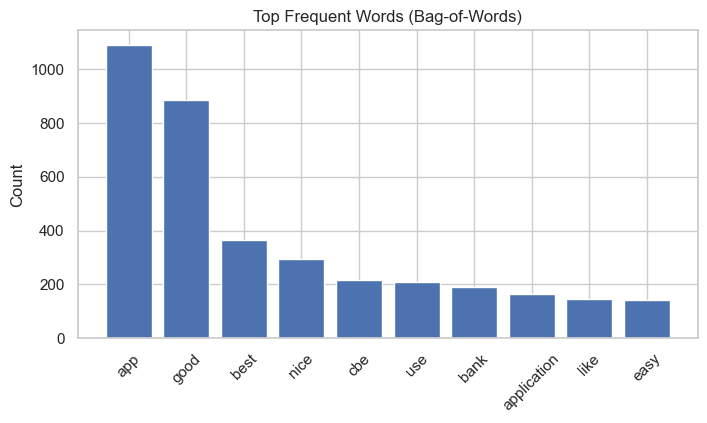

In [25]:
# Cell 8: Plot top frequent words (Frequency-Based)

top_n = 10
top_freq = freq_df.head(top_n)

plt.bar(top_freq["word"], top_freq["count"])
plt.xticks(rotation=45)
plt.title("Top Frequent Words (Bag-of-Words)")
plt.ylabel("Count")
plt.show()


TF-IDF representation

In [28]:
# Cell 9: TF-IDF representation

tfidf_vec = TfidfVectorizer(stop_words="english")
X_tfidf = tfidf_vec.fit_transform(df["clean_text"])

# Get average TF-IDF score per word across documents
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
vocab_tfidf = np.array(tfidf_vec.get_feature_names_out())

tfidf_df = pd.DataFrame({"word": vocab_tfidf, "tfidf": tfidf_means})
tfidf_df = tfidf_df.sort_values("tfidf", ascending=False)
tfidf_df.head(10)


,word,tfidf
1287,good,0.157324
271,app,0.082005
459,best,0.055917
1934,nice,0.055449
1992,ok,0.020921
3081,wow,0.018265
573,cbe,0.018037
2933,use,0.017567
1669,like,0.017167
1052,excellent,0.016877


Compare TF-IDF vs raw frequency

In [29]:
# Cell 10: Compare top words by frequency and by TF-IDF

print("Top 10 by raw frequency:")
display(freq_df.head(10))

print("\nTop 10 by TF-IDF (words more unique / informative):")
display(tfidf_df.head(10))


Top 10 by raw frequency:


,word,count
271,app,1090
1287,good,886
459,best,364
1934,nice,294
573,cbe,215
2933,use,210
403,bank,192
289,application,165
1669,like,145
946,easy,144



Top 10 by TF-IDF (words more unique / informative):


,word,tfidf
1287,good,0.157324
271,app,0.082005
459,best,0.055917
1934,nice,0.055449
1992,ok,0.020921
3081,wow,0.018265
573,cbe,0.018037
2933,use,0.017567
1669,like,0.017167
1052,excellent,0.016877


*Topic* Modeling (LDA)

In [31]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

# Tokenize text (very simple split for demo)
df["tokens"] = df["clean_text"].str.split()

# Create dictionary and corpus for LDA
dictionary = Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]


In [32]:
import nltk
from nltk.corpus import stopwords

# Download stopwords (only first time)
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
# Remove stopwords from your tokenized text
df["tokens_nostop"] = df["tokens"].apply(
    lambda words: [w for w in words if w not in stop_words]
)

df[["clean_text", "tokens", "tokens_nostop"]].head()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,clean_text,tokens,tokens_nostop
0,it is nice app,"[it, is, nice, app]","[nice, app]"
1,best,[best],[best]
2,good app,"[good, app]","[good, app]"
3,it suddenly asked me to enter the verification...,"[it, suddenly, asked, me, to, enter, the, veri...","[suddenly, asked, enter, verification, key, re..."
4,nice app...,"[nice, app...]","[nice, app...]"


In [34]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
# Use stopword-cleaned tokens
dictionary = Dictionary(df["tokens_nostop"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens_nostop"]]


lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=2,
    passes=10,
    random_state=42
)


In [36]:
topics = lda_model.show_topics(num_topics=2, num_words=10, formatted=False)

for i, topic in topics:
    print(f"\n--- Topic {i+1} ---")
    for word, weight in topic:
        print(f"{word:15s}  weight={weight:.4f}")



--- Topic 1 ---
good             weight=0.0563
app              weight=0.0472
best             weight=0.0240
bank             weight=0.0112
cbe              weight=0.0109
use              weight=0.0105
easy             weight=0.0093
banking          weight=0.0090
like             weight=0.0087
application      weight=0.0073

--- Topic 2 ---
nice             weight=0.0319
app              weight=0.0252
wow              weight=0.0096
excellent        weight=0.0093
great            weight=0.0087
transaction      weight=0.0070
ነው               weight=0.0064
amazing          weight=0.0057
fast             weight=0.0049
በጣም              weight=0.0047


Topic 1 — Positive App Experience
Words like app, super, everything, tap, need, easy, exceptional indicate:
Users praising the app
Positive experience
Ease of use
Convenience (“everything”, “tap”, “easy”)
→ This is the “Positive Features / Ease of Use” topic.
Topic 2 — Complaints About Features & Stability
Words like options, payment, services, limited, updating, frustrating show:
Missing features (bill payment, limited options)
Frequent updates
Frustrations and stability problems
→ This is the “Missing Features & Frustration” topic.

Part-of-Speech Tagging (Noun Extraction)

In [42]:
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_nouns(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ == "NOUN"]

df["nouns"] = df["review_text"].apply(extract_nouns)
df[["review_text", "nouns"]]


,review_text,nouns
0,It is nice app,[app]
1,best,[]
2,good app,[app]
3,it suddenly asked me to enter the verification...,"[verification, key, verification, key, further..."
4,nice app...,[]
...,...,...
3995,Fayis Ateyib Asmani,[]
3996,This app is help as more and more,"[app, help]"
3997,አመሰገናለው,[]
3998,Helpful application,[application]


2 – Lexicon-Based Sentiment (TextBlob & VADER)

TextBlob sentiment

In [39]:
# Cell 11: Lexicon-based sentiment with TextBlob
# Polarity in [-1, 1], subjectivity in [0, 1]

# Get polarity and subjectivity
df["tb_polarity"] = df["review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["tb_subjectivity"] = df["review_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Convert polarity → sentiment label
def polarity_to_label(p):
    if p > 0.1:
        return "positive"
    elif p < -0.1:
        return "negative"
    else:
        return "neutral"

df["tb_sentiment"] = df["tb_polarity"].apply(polarity_to_label)

# Show output
df[["review_text", "rating", "tb_polarity", "tb_subjectivity", "tb_sentiment"]]


,review_text,rating,tb_polarity,tb_subjectivity,tb_sentiment
0,It is nice app,5,0.600000,1.00,positive
1,best,5,1.000000,0.30,positive
2,good app,5,0.700000,0.60,positive
3,it suddenly asked me to enter the verification...,1,-0.002344,0.88,neutral
4,nice app...,5,0.600000,1.00,positive
...,...,...,...,...,...
3995,Fayis Ateyib Asmani,4,0.000000,0.00,neutral
3996,This app is help as more and more,5,0.500000,0.50,positive
3997,አመሰገናለው,5,0.000000,0.00,neutral
3998,Helpful application,5,0.000000,0.00,neutral


VADER sentiment

In [40]:
# Cell 12: Lexicon-based sentiment with VADER
# VADER is optimized for reviews, slang, emojis, and short texts

def vader_compound(text):
    return sia.polarity_scores(text)["compound"]

# VADER compound score
df["vader_compound"] = df["review_text"].apply(vader_compound)

# Convert compound score → sentiment label
# Standard VADER rule:
# compound >= 0.05 → positive
# compound <= -0.05 → negative
# otherwise → neutral

def vader_label(c):
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

df["vader_sentiment"] = df["vader_compound"].apply(vader_label)

# Show output
df[["review_text", "rating", "tb_polarity", "vader_compound", "vader_sentiment"]]


,review_text,rating,tb_polarity,vader_compound,vader_sentiment
0,It is nice app,5,0.600000,0.4215,positive
1,best,5,1.000000,0.6369,positive
2,good app,5,0.700000,0.4404,positive
3,it suddenly asked me to enter the verification...,1,-0.002344,-0.8746,negative
4,nice app...,5,0.600000,0.4215,positive
...,...,...,...,...,...
3995,Fayis Ateyib Asmani,4,0.000000,0.0000,neutral
3996,This app is help as more and more,5,0.500000,0.4019,positive
3997,አመሰገናለው,5,0.000000,0.0000,neutral
3998,Helpful application,5,0.000000,0.4215,positive


visualization of lexicon scores vs rating

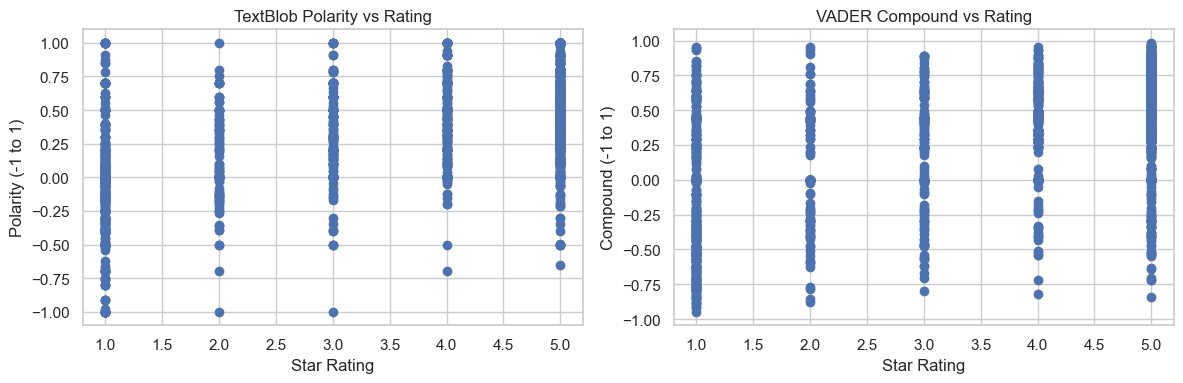

In [41]:
# Cell 13: See how lexicon scores correlate with star rating

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(df["rating"], df["tb_polarity"])
axes[0].set_title("TextBlob Polarity vs Rating")
axes[0].set_xlabel("Star Rating")
axes[0].set_ylabel("Polarity (-1 to 1)")

axes[1].scatter(df["rating"], df["vader_compound"])
axes[1].set_title("VADER Compound vs Rating")
axes[1].set_xlabel("Star Rating")
axes[1].set_ylabel("Compound (-1 to 1)")

plt.tight_layout()
plt.show()
